WineMLP(
  (net): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=300, bias=True)
  )
)
net.0.weight 768
net.0.bias 64
net.2.weight 2048
net.2.bias 32
net.4.weight 9600
net.4.bias 300
[01] train_loss=142.7650 | val_loss=73.9794
[02] train_loss=43.3041 | val_loss=8.9634
[03] train_loss=11.4710 | val_loss=6.1059
[04] train_loss=6.7722 | val_loss=5.5555
[05] train_loss=3.9850 | val_loss=2.1030
[06] train_loss=2.9487 | val_loss=1.8348
[07] train_loss=2.0913 | val_loss=2.0895
[08] train_loss=1.7947 | val_loss=1.8956
[09] train_loss=1.3255 | val_loss=1.3257
[10] train_loss=1.1523 | val_loss=1.3395
[11] train_loss=1.3179 | val_loss=1.7763
[12] train_loss=1.5729 | val_loss=1.5333
[13] train_loss=1.3765 | val_loss=1.5063
[14] train_loss=1.5742 | val_loss=1.5404
[15] train_loss=1.2142 | val_loss=1.8050
[16] train_loss=1.0946 | val_loss=1

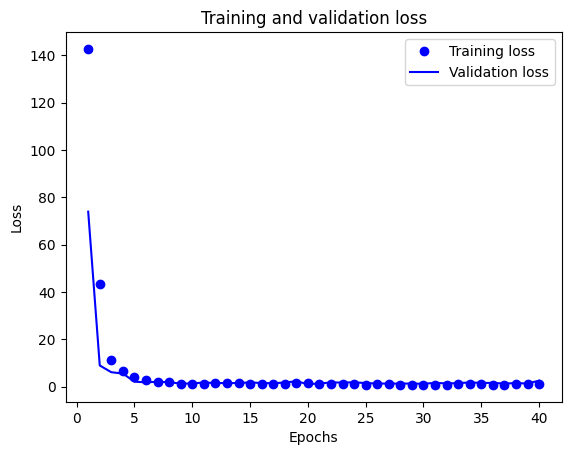

Final Test Accuracy: 0.42


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


disney_data = pd.read_csv("disney_princess.csv")#https://www.kaggle.com/datasets/hamnakaleemds/disney-princess-popularity-dataset?resource=download


disney_data = disney_data.drop(['SidekickType', 'MagicType', 'VillainType'], axis = 1)

disney_data['HasSoloSong'] = LabelEncoder().fit_transform(disney_data['HasSoloSong'])


num_cols = disney_data.select_dtypes(include=["int64", "float64"]).columns


X = disney_data[num_cols].drop(columns=['HasSoloSong'])
num_input_feat = X.shape[1]
y = disney_data['HasSoloSong']
num_outputs = len(disney_data['HasSoloSong'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test  = torch.tensor(X_test.values,  dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test  = torch.tensor(y_test.values,  dtype=torch.long)

# Створюємо TensorDataset
train_data = TensorDataset(X_train, y_train)
test_data  = TensorDataset(X_test, y_test)

# Створюємо DataLoader-и
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=32, shuffle=False)

# Model: MLP
class WineMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_input_feat, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, num_outputs)   # logits для 3 класів
        )

    def forward(self, x):
        logits = self.net(x)
        return logits

model = WineMLP().to(device)
print(model)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 40
# навчання
train_loss_history = []
val_loss_history = []
for epoch in range(n_epochs):

    # --- train ---
    model.train()
    train_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # --- validation ---
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    print(f"[{epoch+1:02d}] train_loss={train_loss:.4f} | val_loss={val_loss:.4f}")

import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)
plt.plot(epochs, train_loss_history, "bo", label="Training loss")
plt.plot(epochs, val_loss_history, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

#test accuracy (just to print once more)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

print(f"Final Test Accuracy: {correct/total:.2f}")
